## 1. Khởi tạo và nạp thư viện + dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, auc, ConfusionMatrixDisplay
)

from google.colab import drive
drive.mount('/content/drive')

# Đọc dữ liệu
df = pd.read_csv('/content/drive/MyDrive/hotel-classification-dataset.csv')


Mounted at /content/drive


## 2. Tiền xử lý dữ liệu

In [2]:
df.duplicated().sum()

np.int64(174)

In [3]:
# Giữ lại dòng đầu tiên, xóa các dòng còn lại
df.drop_duplicates(keep='first', inplace=True)
# Kiểm tra lại
df.duplicated().sum()

np.int64(0)

In [4]:
  # Kiểm tra thiếu
  print(df.isnull().sum())

  # Xóa cột không cần thiết
  df.drop(columns=['Review_Date', 'lat', 'lng','days_since_review'], inplace=True)

  print(df.isnull().sum())

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Tags                                             0
days_since_review                                0
lat                                           1824
lng                                           1824
Reviewer_Score                                   0
dtype: int64
Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Average_Score           

##Làm sạch dữ liệu *review*

In [5]:
def normalize_value(value):
    value = str(value).strip().lower()
    if value in ['nothing', 'no negative', ' nothing', ' no negative', 'no positive', ' no postive']:
        return 'nothing'
    return value

df['Negative_Review'] = df['Negative_Review'].apply(normalize_value)
df['Positive_Review'] = df['Positive_Review'].apply(normalize_value)

df['Negative_Review'] = df['Negative_Review'].apply(lambda x: 0 if x == "nothing" else 1)
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: 0 if x == "nothing" else 1)


##Xử lý cột "Tags" (MultiLabel Binarization)

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter

df['Tags'] = df['Tags'].apply(lambda x: eval(str(x).strip()))

# Chọn top 20 tag phổ biến nhất
all_tags = [tag for tags in df['Tags'] for tag in tags]
top_tags = [tag for tag, count in Counter(all_tags).most_common(20)]

# Lọc và One-hot encode
df['Tags_filtered'] = df['Tags'].apply(lambda tags: [tag if tag in top_tags else 'other' for tag in tags])
mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['Tags_filtered'])
df = pd.concat([df.drop(['Tags', 'Tags_filtered'], axis=1), pd.DataFrame(tags_encoded, columns=mlb.classes_)], axis=1)
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,...,Standard Double Room,Standard Double or Twin Room,Stayed 1 night,Stayed 2 nights,Stayed 3 nights,Stayed 4 nights,Stayed 5 nights,Submitted from a mobile device,Superior Double Room,other
0,44 Grosvenor Square Westminster Borough London...,806.0,7.8,Millennium Hotel London Mayfair,Qatar,1.0,6.0,3117.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Bryanston Street Marble Arch Westminster Borou...,908.0,8.5,Amba Hotel Marble Arch,United Kingdom,0.0,2.0,3980.0,1.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,Via Senigallia 6 20161 Milan Italy,904.0,8.1,Hotel Da Vinci,Belgium,1.0,14.0,16670.0,1.0,19.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17 rue de l Arcade 8th arr 75008 Paris France,230.0,8.6,H tel Bedford,United Kingdom,0.0,2.0,1703.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,57 59 Welbeck Street Westminster Borough Londo...,241.0,7.5,Holiday Inn London Oxford Circus,Israel,1.0,58.0,1287.0,1.0,17.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##3. Phân tích dữ liệu số

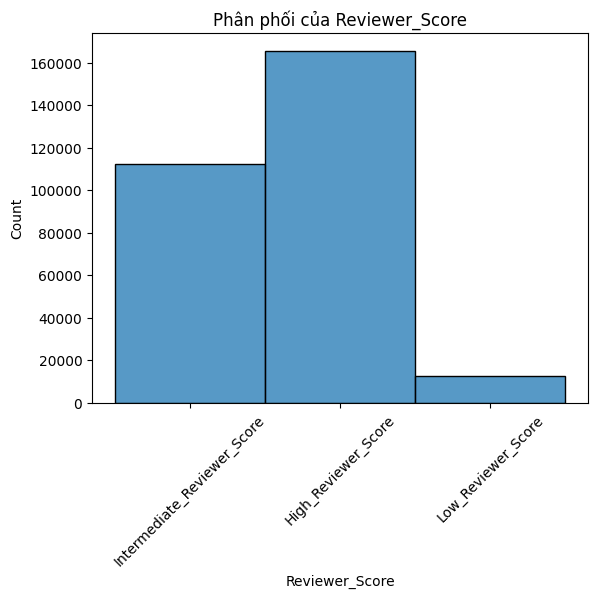

In [7]:
# Histogram cho nhãn
sns.histplot(x=df['Reviewer_Score'])
plt.title("Phân phối của Reviewer_Score")
plt.xticks(rotation=45)
plt.show()

# Heatmap tương quan
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 2]

##4. Xử lý ngoại lai

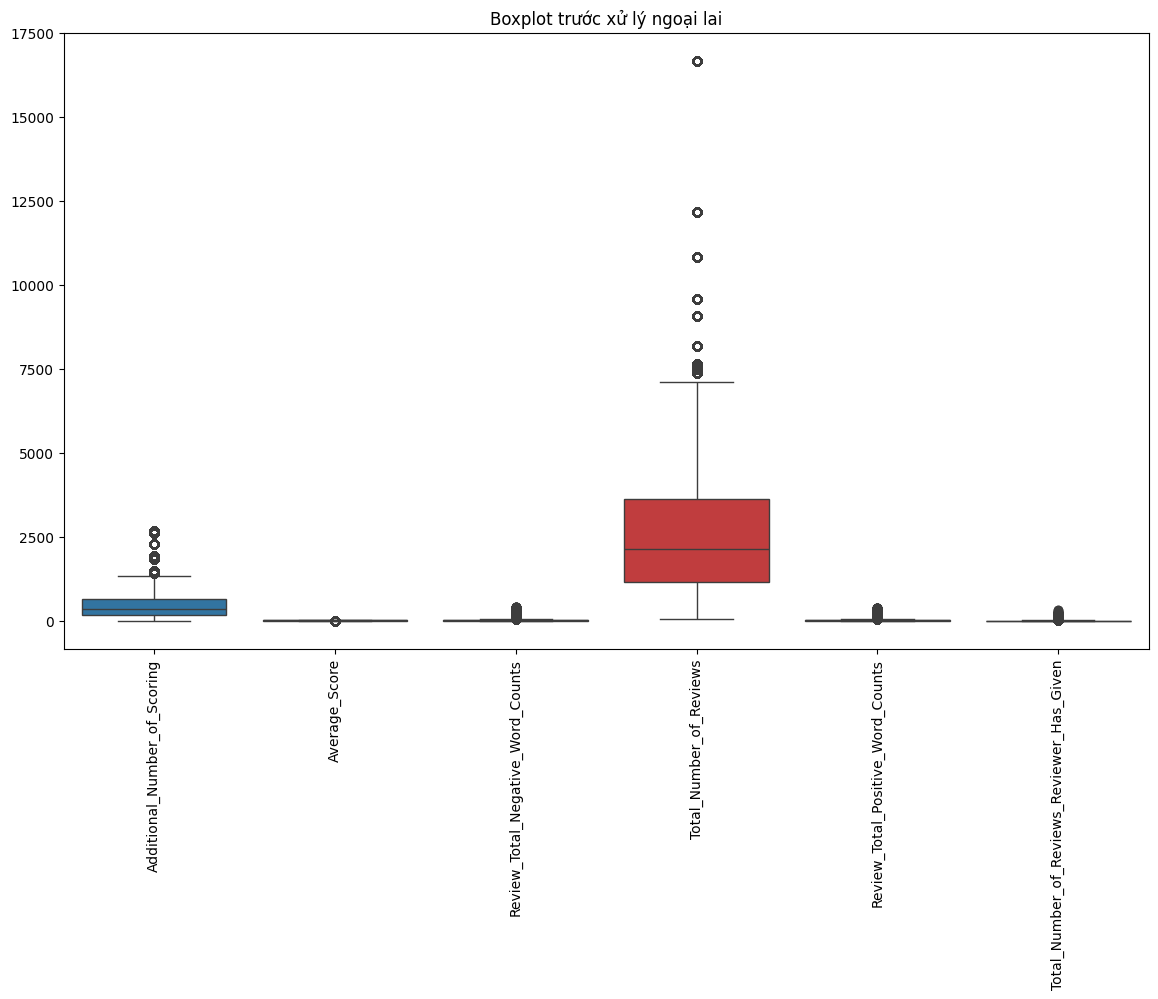

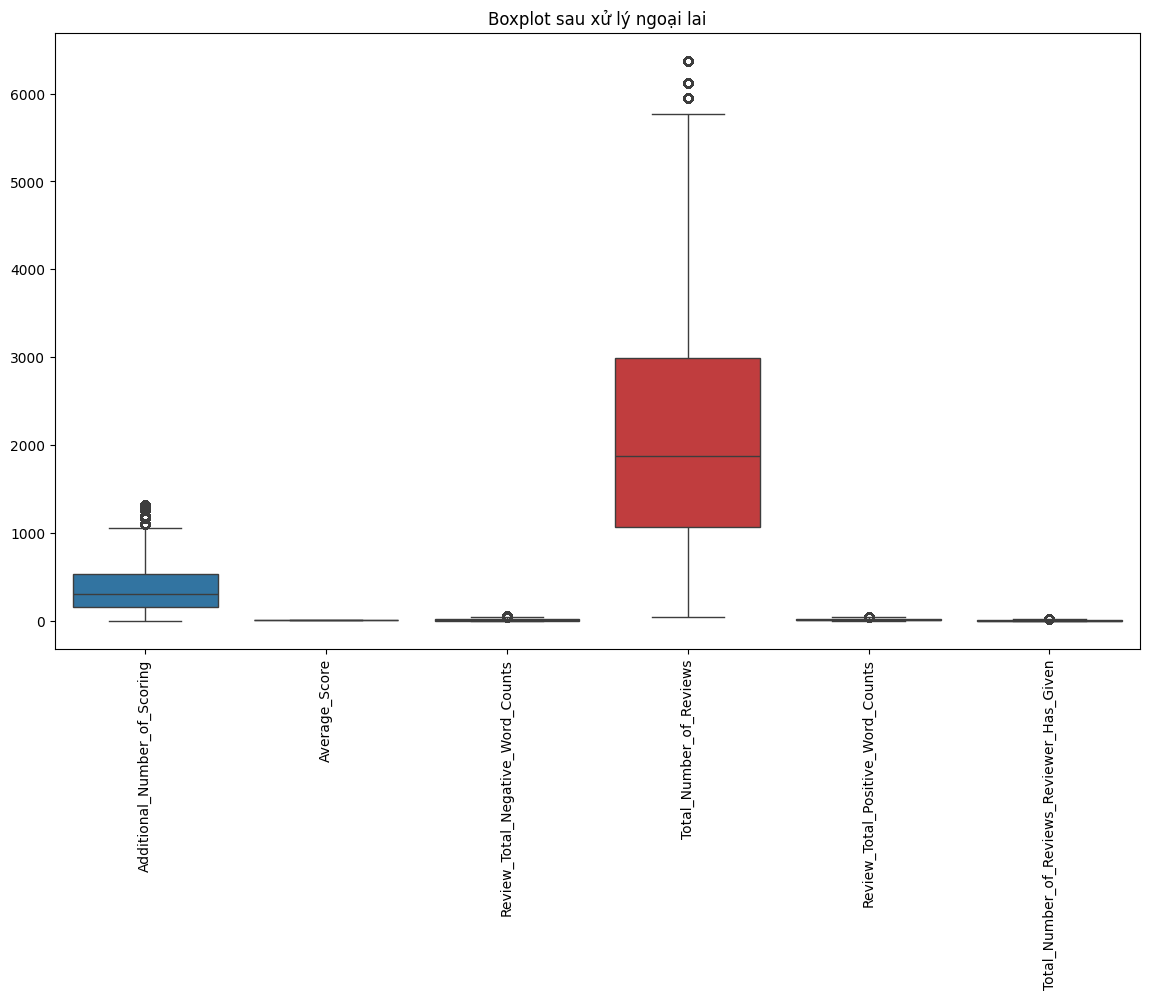

In [8]:
# Boxplot trước khi xử lý
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[continuous_cols[:10]])
plt.xticks(rotation=90)
plt.title("Boxplot trước xử lý ngoại lai")
plt.show()

# Loại bỏ ngoại lai bằng IQR
for col in continuous_cols[:10]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

# Boxplot sau xử lý
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[continuous_cols[:10]])
plt.xticks(rotation=90)
plt.title("Boxplot sau xử lý ngoại lai")
plt.show()


##5. Gán nhãn mục tiêu

<Axes: xlabel='Reviewer_Score', ylabel='Count'>

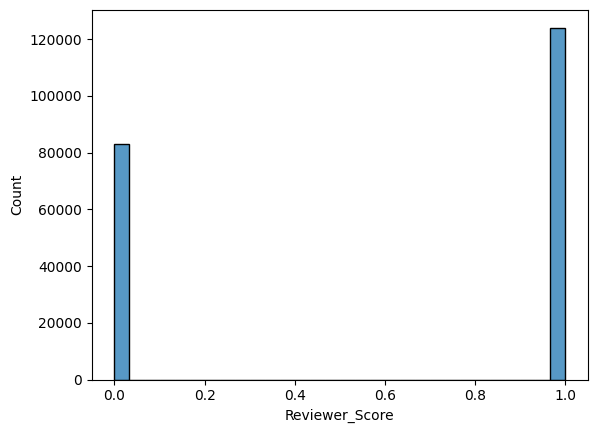

In [9]:
mapping = {
    "Low_Reviewer_Score": 0,
    "Intermediate_Reviewer_Score": 0,
    "High_Reviewer_Score": 1
}
df['Reviewer_Score'] = df['Reviewer_Score'].map(mapping)
sns.histplot(x=df['Reviewer_Score'])

##6. Mã hóa + chia dữ liệu

In [10]:
cate_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cate_cols:
    df[col] = le.fit_transform(df[col])

X = df.drop(columns=['Reviewer_Score'])
y = df['Reviewer_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##7. Cân bằng dữ liệu với SMOTE + chuẩn hóa

In [11]:
from sklearn.impute import SimpleImputer

# Kiểm tra giá trị NaN
print("Số giá trị NaN trong X_train:", X_train.isnull().sum().sum())
print("Số giá trị NaN trong y_train:", y_train.isnull().sum())

# Sử dụng SimpleImputer để điền giá trị NaN bằng giá trị trung bình
imputer = SimpleImputer(strategy='mean')  # Có thể thay 'mean' bằng 'median' hoặc 'constant'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Tiếp tục với SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Số giá trị NaN trong X_train: 1911
Số giá trị NaN trong y_train: 0


##8. Huấn luyện mô hình

In [12]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [13]:
y_pred = logreg.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69     24965
           1       0.81      0.71      0.76     37132

    accuracy                           0.73     62097
   macro avg       0.72      0.73      0.72     62097
weighted avg       0.74      0.73      0.73     62097



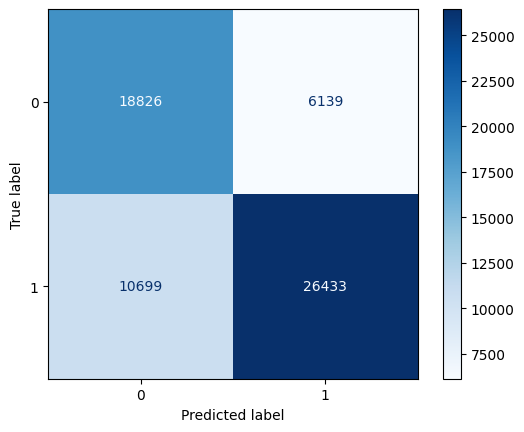

In [15]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap = 'Blues')

##9. Tối ưu hóa mô hình, chọn ngưỡng tốt nhất

In [16]:
param_grid = {
    'penalty': ['l2'],               # Thêm cả L1 và L2
    'C': [0.1],          # Điều chỉnh mức độ regularization
    'solver': ['liblinear'],       # Các solver hỗ trợ L1/L2
    'max_iter': [100],           # Cho phép hội tụ lâu hơn nếu cần
    'class_weight': [None, 'balanced']     # Kiểm tra xử lý mất cân bằng
}

In [17]:
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1], 'class_weight': [None, 'balanced'],
                         'max_iter': [100], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [18]:
best_logreg = grid.best_estimator_

In [19]:
y_proba = grid.predict_proba(X_test)[:, 1]

In [20]:
threshold = np.arange(0.0, 1.01, 0.01)
results = []

for t in threshold:
    y_pred = (y_proba > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append((t, fp, fn, tp, tn))

In [21]:
df_thresh = pd.DataFrame(results, columns=['threshold', 'fp', 'fn', 'tp', 'tn'])
df_thresh['Precision'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fp'])
df_thresh['Recall'] = df_thresh['tp'] / (df_thresh['tp'] + df_thresh['fn'])

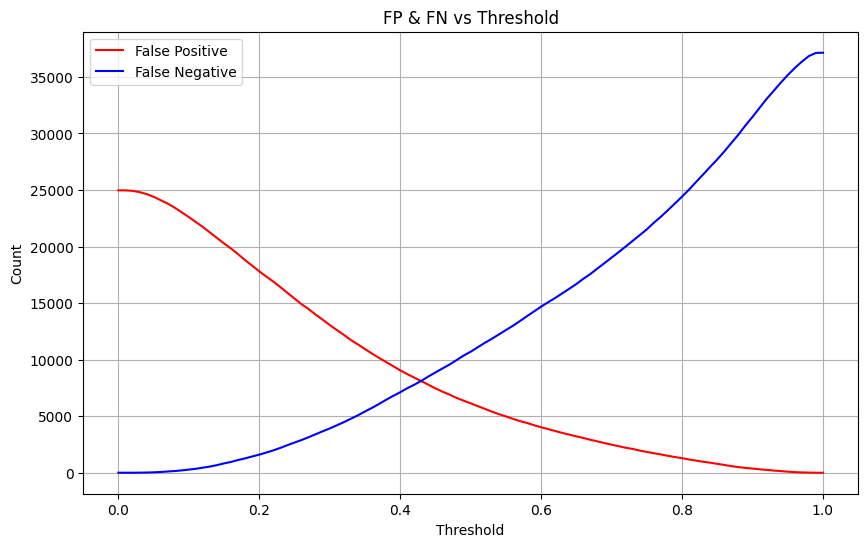

In [22]:
plt.figure(figsize=(10,6))
plt.plot(df_thresh['threshold'], df_thresh['fp'], label='False Positive', color='red')
plt.plot(df_thresh['threshold'], df_thresh['fn'], label='False Negative', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('FP & FN vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Threshold = 0.43
y_pred_best = (y_proba > 0.43).astype(int)

In [24]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68     24965
           1       0.78      0.78      0.78     37132

    accuracy                           0.74     62097
   macro avg       0.73      0.73      0.73     62097
weighted avg       0.74      0.74      0.74     62097



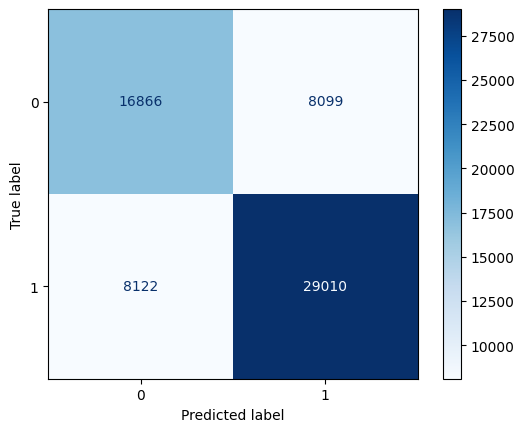

In [25]:
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp.plot(cmap="Blues")

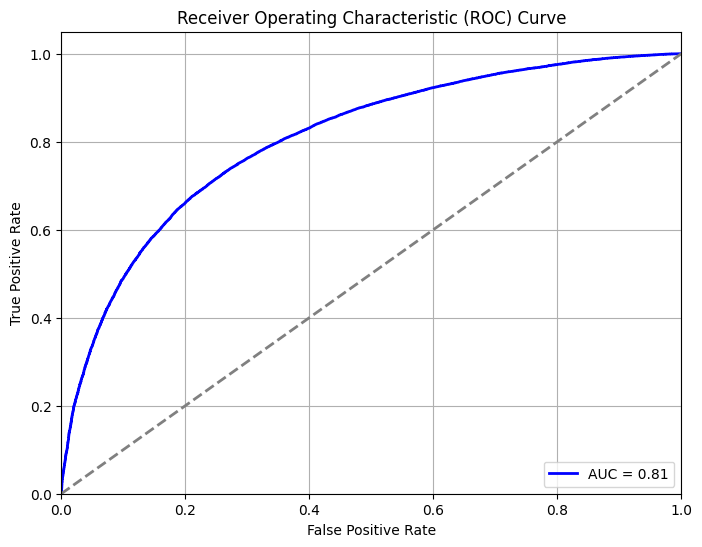

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # đường random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [35]:
import pandas as pd
import numpy as np

def predict_hotel_review(new_data, imputer, scaler, best_logreg, le_dict, mlb, threshold=0.43):
    df_new = pd.DataFrame([new_data])
    for col, le in le_dict.items():
        if col in df_new.columns:
            df_new[col] = df_new[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
            df_new[col] = le.transform(df_new[col])

    # Preprocess Negative_Review and Positive_Review
    df_new['Negative_Review'] = df_new['Negative_Review'].apply(
        lambda x: 0 if str(x).strip().lower() in ['nothing', 'no negative'] else 1
    )
    df_new['Positive_Review'] = df_new['Positive_Review'].apply(
        lambda x: 0 if str(x).strip().lower() in ['nothing', 'no positive'] else 1
    )

    # Preprocess Tags
    df_new['Tags'] = df_new['Tags'].apply(lambda x: eval(str(x).strip()) if isinstance(x, str) else x)
    df_new['Tags_filtered'] = df_new['Tags'].apply(
        lambda tags: [tag if tag in mlb.classes_ else 'other' for tag in tags]
    )
    tags_encoded = mlb.transform(df_new['Tags_filtered'])
    tags_df = pd.DataFrame(tags_encoded, columns=mlb.classes_)

    # Drop original Tags and Tags_filtered, combine with encoded tags
    df_new = df_new.drop(['Tags', 'Tags_filtered'], axis=1)
    df_new = pd.concat([df_new, tags_df], axis=1)

    # Ensure the feature order matches the training data
    df_new = df_new[X.columns]

    # Apply imputer and scaler
    df_new = imputer.transform(df_new)
    df_new = scaler.transform(df_new)

    # Predict probability and apply threshold
    proba = best_logreg.predict_proba(df_new)[:, 1]
    prediction = (proba > threshold).astype(int)

    return prediction[0], proba[0]

# Create a dictionary of LabelEncoders for categorical columns
le_dict = {col: le for col in cate_cols}  # Assuming cate_cols is available from your code


sample_input = {
    'Hotel_Name': 'Amba Hotel Marble Arch',  # Example hotel name
    'Average_Score': 7.8,
    'Total_Number_of_Reviews': 3980,
    'Reviewer_Nationality': 'VietNam',
    'Negative_Review': 'Nothing',
    'Positive_Review': 'Service and the room',
    'Review_Total_Negative_Word_Counts': 2,
    'Review_Total_Positive_Word_Counts': 5,
    'Total_Number_of_Reviews_Reviewer_Has_Given': 1,
    'Tags': [' Leisure trip ', ' Group ', ' Standard Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device '],

    'Additional_Number_of_Scoring': 806,

}

for col in X.columns:
    if col not in sample_input and col not in mlb.classes_:
        sample_input[col] = 0

prediction, probability = predict_hotel_review(
    sample_input, imputer, scaler, best_logreg, le_dict, mlb, threshold=0.43
)

print(f"Sample Input: {sample_input}")
print(f"Prediction: {'Cao cấp' if prediction == 1 else 'Bình dân'}")

Sample Input: {'Hotel_Name': 'Amba Hotel Marble Arch', 'Average_Score': 7.8, 'Total_Number_of_Reviews': 3980, 'Reviewer_Nationality': 'VietNam', 'Negative_Review': 'Nothing', 'Positive_Review': 'Service and the room', 'Review_Total_Negative_Word_Counts': 2, 'Review_Total_Positive_Word_Counts': 5, 'Total_Number_of_Reviews_Reviewer_Has_Given': 1, 'Tags': [' Leisure trip ', ' Group ', ' Standard Twin Room ', ' Stayed 3 nights ', ' Submitted from a mobile device '], 'Additional_Number_of_Scoring': 806, 'Hotel_Address': 0}
Prediction: Cao cấp
